# HuggingFace : dima806/mushrooms_image_detection
## Based on Vision Transformer (ViTForImageClassification)
> https://huggingface.co/dima806/mushrooms_image_detection

Utilisation du modèle de classification pré-entrainé sur 100 espèces de champignons Russe par Dmytro Iakubovskyi.
Entrainé sur 233480 images, ce modèle obtient une précision de 89%.

In [46]:
import os
import PIL
import requests
import pathlib
from tqdm import tqdm
import numpy as np
import pandas as pd
import time
import datetime

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm

from sklearn import metrics
from sklearn.metrics import confusion_matrix

from datasets import Dataset, Image, ClassLabel
import torch

In [2]:
# Load model directly
# !pip install transformers
from transformers import AutoImageProcessor, AutoModelForImageClassification

processor = AutoImageProcessor.from_pretrained("dima806/mushrooms_image_detection")
model = AutoModelForImageClassification.from_pretrained("dima806/mushrooms_image_detection")
model

2024-10-03 12:22:17.885961: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-03 12:22:17.990532: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-03 12:22:18.037996: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-03 12:22:18.134027: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-03 12:22:18.154606: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-03 12:22:18.284918: I tensorflow/core/platform/cpu_feature_gu

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTSdpaAttention(
            (attention): ViTSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_fe

# Test de prediction sur une image d'Amanita Muscaria

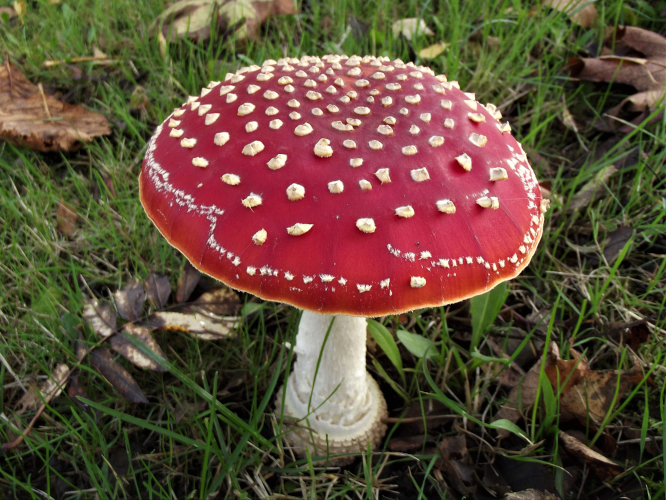

In [7]:
image = PIL.Image.open("predict_001.jpg")
image

In [11]:
inputs = processor(image, return_tensors="pt")
inputs.keys()

dict_keys(['pixel_values'])

In [12]:
outputs = model(**inputs)
outputs.keys()

odict_keys(['logits'])

In [16]:
logits = outputs.logits
logits

tensor([[-5.8014e-01,  7.7951e-01, -3.0195e-01, -1.3132e-01, -5.4755e-01,
         -3.9816e-01, -1.4269e-01, -1.0287e-01, -1.5696e-01,  1.5520e-01,
         -5.4971e-01, -3.5725e-01, -8.5262e-01, -1.0225e+00,  9.4707e+00,
          3.9527e-01, -2.8623e-01, -4.8327e-01, -1.7294e-01, -7.2667e-01,
          1.1936e-02,  1.1253e-01, -7.0803e-01, -2.0618e-01, -1.0745e+00,
         -6.9442e-01, -5.2645e-01, -5.9972e-01, -4.9382e-01, -7.5656e-01,
         -7.9050e-02, -6.5911e-03, -3.4002e-01,  1.2853e-01, -2.8462e-01,
         -3.3036e-01,  3.2836e-01, -6.9960e-02,  7.1488e-01,  1.0279e+00,
          3.0302e-01,  3.8514e-01,  4.5527e-01, -3.6441e-01,  5.9003e-02,
         -4.6722e-01,  6.1019e-01, -3.2779e-01,  6.1820e-02, -3.6684e-01,
          1.7810e-01, -4.2602e-01, -1.2833e-01, -7.8447e-02, -1.0111e+00,
          1.7913e-01, -3.1935e-01,  1.1474e-01, -8.3710e-01, -5.6235e-01,
          9.6011e-03, -9.5199e-02, -2.0762e-01,  1.1282e-01, -3.6013e-01,
         -8.4758e-01, -1.2496e-01,  4.

In [17]:
predicted_class_index = logits.argmax(-1).item()
predicted_class_index

14

Ici, la classe 14 équivaut bien à Amanita Muscaria sur le dataset russe. Nous allons récupérer les labels.

In [44]:
dict_labels = {'Urnula craterium': 0, 'Leccinum albostipitatum': 1, 'Lactarius deliciosus': 2, 'Clitocybe nebularis': 3, 'Hypholoma fasciculare': 4, 'Lactarius torminosus': 5, 'Lycoperdon perlatum': 6, 'Verpa bohemica': 7, 'Schizophyllum commune': 8, 'Leccinum aurantiacum': 9, 'Phellinus igniarius': 10, 'Suillus luteus': 11, 'Coltricia perennis': 12, 'Cetraria islandica': 13, 'Amanita muscaria': 14, 'Pholiota aurivella': 15, 'Trichaptum biforme': 16, 'Artomyces pyxidatus': 17, 'Calocera viscosa': 18, 'Sarcosoma globosum': 19, 'Evernia prunastri': 20, 'Laetiporus sulphureus': 21, 'Lobaria pulmonaria': 22, 'Bjerkandera adusta': 23, 'Vulpicida pinastri': 24, 'Imleria badia': 25, 'Evernia mesomorpha': 26, 'Physcia adscendens': 27, 'Coprinellus micaceus': 28, 'Armillaria borealis': 29, 'Trametes ochracea': 30, 'Cantharellus cibarius': 31, 'Pseudevernia furfuracea': 32, 'Tremella mesenterica': 33, 'Gyromitra infula': 34, 'Leccinum versipelle': 35, 'Mutinus ravenelii': 36, 'Pholiota squarrosa': 37, 'Amanita rubescens': 38, 'Amanita pantherina': 39, 'Sarcoscypha austriaca': 40, 'Boletus edulis': 41, 'Coprinus comatus': 42, 'Merulius tremellosus': 43, 'Stropharia aeruginosa': 44, 'Cladonia fimbriata': 45, 'Suillus grevillei': 46, 'Apioperdon pyriforme': 47, 'Cerioporus squamosus': 48, 'Leccinum scabrum': 49, 'Rhytisma acerinum': 50, 'Hypholoma lateritium': 51, 'Flammulina velutipes': 52, 'Tricholomopsis rutilans': 53, 'Coprinopsis atramentaria': 54, 'Trametes versicolor': 55, 'Graphis scripta': 56, 'Ganoderma applanatum': 57, 'Phellinus tremulae': 58, 'Peltigera aphthosa': 59, 'Parmelia sulcata': 60, 'Fomitopsis betulina': 61, 'Pleurotus pulmonarius': 62, 'Fomitopsis pinicola': 63, 'Daedaleopsis confragosa': 64, 'Hericium coralloides': 65, 'Trametes hirsuta': 66, 'Coprinellus disseminatus': 67, 'Kuehneromyces mutabilis': 68, 'Pleurotus ostreatus': 69, 'Phlebia radiata': 70, 'Boletus reticulatus': 71, 'Phallus impudicus': 72, 'Macrolepiota procera': 73, 'Fomes fomentarius': 74, 'Suillus granulatus': 75, 'Gyromitra esculenta': 76, 'Xanthoria parietina': 77, 'Nectria cinnabarina': 78, 'Sarcomyxa serotina': 79, 'Inonotus obliquus': 80, 'Panellus stipticus': 81, 'Hypogymnia physodes': 82, 'Hygrophoropsis aurantiaca': 83, 'Cladonia rangiferina': 84, 'Platismatia glauca': 85, 'Calycina citrina': 86, 'Cladonia stellaris': 87, 'Amanita citrina': 88, 'Lepista nuda': 89, 'Gyromitra gigas': 90, 'Crucibulum laeve': 91, 'Daedaleopsis tricolor': 92, 'Stereum hirsutum': 93, 'Paxillus involutus': 94, 'Lactarius turpis': 95, 'Chlorociboria aeruginascens': 96, 'Chondrostereum purpureum': 97, 'Phaeophyscia orbicularis': 98, 'Peltigera praetextata': 99}
dict_labels.items()

dict_items([('Urnula craterium', 0), ('Leccinum albostipitatum', 1), ('Lactarius deliciosus', 2), ('Clitocybe nebularis', 3), ('Hypholoma fasciculare', 4), ('Lactarius torminosus', 5), ('Lycoperdon perlatum', 6), ('Verpa bohemica', 7), ('Schizophyllum commune', 8), ('Leccinum aurantiacum', 9), ('Phellinus igniarius', 10), ('Suillus luteus', 11), ('Coltricia perennis', 12), ('Cetraria islandica', 13), ('Amanita muscaria', 14), ('Pholiota aurivella', 15), ('Trichaptum biforme', 16), ('Artomyces pyxidatus', 17), ('Calocera viscosa', 18), ('Sarcosoma globosum', 19), ('Evernia prunastri', 20), ('Laetiporus sulphureus', 21), ('Lobaria pulmonaria', 22), ('Bjerkandera adusta', 23), ('Vulpicida pinastri', 24), ('Imleria badia', 25), ('Evernia mesomorpha', 26), ('Physcia adscendens', 27), ('Coprinellus micaceus', 28), ('Armillaria borealis', 29), ('Trametes ochracea', 30), ('Cantharellus cibarius', 31), ('Pseudevernia furfuracea', 32), ('Tremella mesenterica', 33), ('Gyromitra infula', 34), ('Le

In [45]:
# Fonction pour récupérer le nom du label

def champi_label(dictionnaire, valeur_cible):
  for cle, valeur in dictionnaire.items():
    if valeur == valeur_cible:
      return cle
  return None

print(champi_label(dict_labels, predicted_class_index))

Amanita muscaria


# Fonction de prediction complète avec une URL

In [69]:
def champi_predict_dima806_mid(url):
    response = requests.get(url, stream=True)
    image = PIL.Image.open(response.raw)
    inputs = processor(image, return_tensors="pt")
    outputs = model(**inputs)
    logits = outputs.logits
    predicted_class_index = logits.argmax(-1).item()
    return print("PREDICTION :", champi_label(dict_labels, predicted_class_index))

PHOLIOTA SQUARROSA
PREDICTION : Pholiota squarrosa
----------


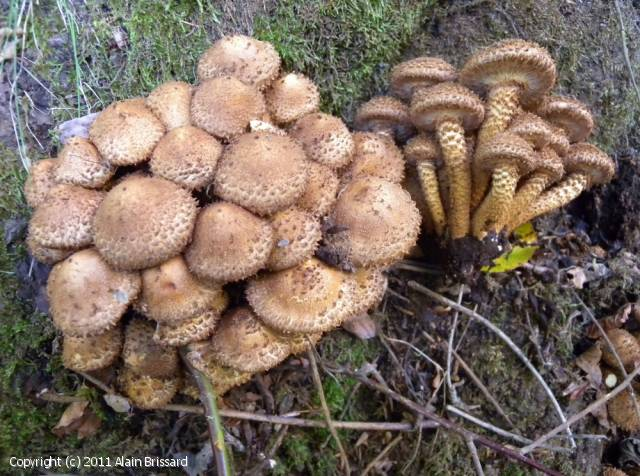

In [73]:
name = "Pholiota Squarrosa"
url = "https://www.mycodb.fr/photos/Pholiota_squarrosa_2011_ab_1.jpg"
print(str.upper(name))
champi_predict_dima806_mid(url)
print('----------')
response = requests.get(url, stream=True)
PIL.Image.open(response.raw)

MUTINUS RAVENELII
PREDICTION : Mutinus ravenelii
----------


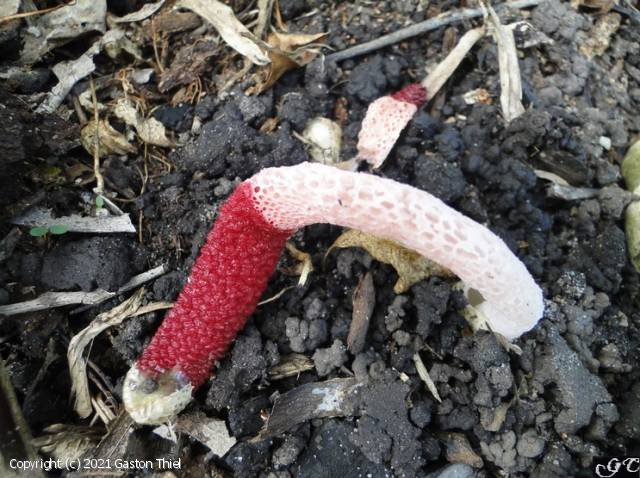

In [74]:
name = "Mutinus Ravenelii"
url = "https://www.mycodb.fr/photos/Mutinus_ravenelii_2021_gt_1.jpg"
print(str.upper(name))
champi_predict_dima806_mid(url)
print('----------')
response = requests.get(url, stream=True)
PIL.Image.open(response.raw)

BJERKANDERA ADUSTA
PREDICTION : Trametes versicolor
----------


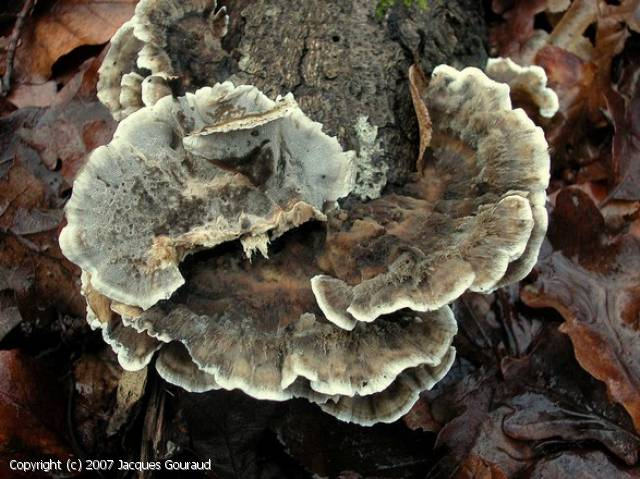

In [75]:
name = "Bjerkandera Adusta"
url = "https://www.mycodb.fr/photos/Bjerkandera_adusta_2007_jg_1.jpg"
print(str.upper(name))
champi_predict_dima806_mid(url)
print('----------')
response = requests.get(url, stream=True)
PIL.Image.open(response.raw)

CALOCERA VISCOSA
PREDICTION : Calocera viscosa
----------


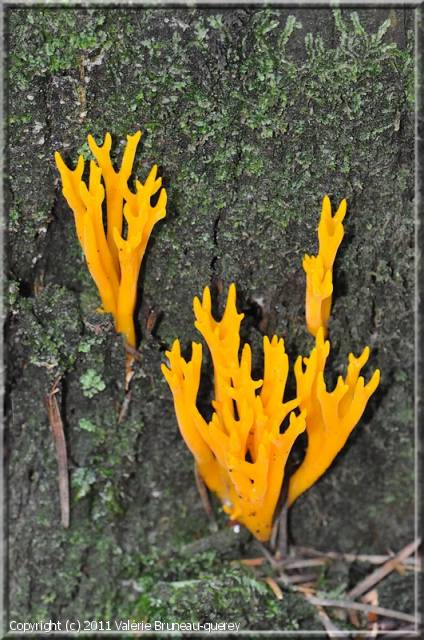

In [76]:
name = "Calocera Viscosa"
url = "https://www.mycodb.fr/photos/Calocera_viscosa_2011_vb_2.jpg"
print(str.upper(name))
champi_predict_dima806_mid(url)
print('----------')
response = requests.get(url, stream=True)
PIL.Image.open(response.raw)